# Latin Hypercube Sampling in MUSICA
In the previous example, all of the grid cells had to be filled in manually with data.</br>
This makes it not practically useful on its own since it would be tedious to make a system with many grid cells.</br>
One solution to this is Latin Hypercube Sampling (LHS), a statistical method for generating multidimensional random samples.</br>
It avoids the problem of clustering that can sometimes appear in pure random sampling.</br>
This tutorial will go over a simple example of utilizing LHS to run a multi-grid-cell solver in MUSICA.</br>
For documentation on Latin Hypercube Sampling, go [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html).

## 1. Importing Libraries
Below is a list of the required libraries for this tutorial:

In [1]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
from scipy.stats import qmc
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Rerunning Previous Code
This is simply a copy of the first 4 steps from the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb) since the code is identical aside from the number of grid cells being increased.</br>
If you would like to view the explanation for this code, refer to the hyperlink on the above line.

In [2]:
A = mc.Species(name="A")
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C]
gas = mc.Phase(name="gas", species=species)

r1 = mc.Arrhenius(
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2]
)

solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

num_grid_cells = 100
state = solver.create_state(num_grid_cells)

## 3. Creating and Scaling a Latin Hypercube Sampler
This Latin Hypercube Sampler uses the same 5 dimensions as the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb) to randomize each of the individual systems, being:
* temperature (Kelvin),
* pressure (Pascals), and
* the concentrations of each of the species (mol/m<sup>3</sup>).

Next, the LHS is created with the provided number of dimensions with a randomized sample that will be scaled by the sampler.</br>
The upper and lower bounds for each of the five dimensions are then set, and the sample is scaled with those bounds by the LHS.</br>
Do note as before that the ordering inside the bounding arrays matters and cannot be changed.

In [3]:
ndim = 5
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 10, 10, 10] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

## 4. Splitting up the Array Output and Running the Solver
This code follows the same flow as the [Multiple Grid Cells Tutorial](1.%20multiple_grid_cells.ipynb) but with the new LHS values.</br>
The only notable change is the old <i>box_model_values</i> array becoming the <i>sample_scaled</i> output array from the LHS.

In [4]:
temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 60
curr_time = 0

while curr_time <= sim_length:
    solver.solve(state, curr_time)
    concentrations_solved.append(state.get_concentrations())
    curr_time += time_step_length

## 5. Expanding out the DataFrame (Advanced; Optional Read)
The intention of this code snippet is to split up each grid cell for each time step onto a separate row in the DataFrame so they can be averaged when plotted.</br>
This will produce a confidence interval for each time step since there will be a set of unique values at every time step for each species.</br>
As an example, if there are 2 grid cells and 5 time steps, the data table will have 10 rows, with the first being the first grid cell for the first time step, the second row being the second grid cell for the first time step, the third row being the first grid cell for the second time step, and so on.</br>
You can see this pattern in the displayed DataFrame as well.</br>
After the expansion of the DataFrame, adding the other columns is fairly similar; they are simply given more rows since the number of rows is now the product of the number of grid cells and the number of time steps.</br>
The time column is notably different, however, since each time step has to be repeated for every grid cell.</br>
Due to the complexity of this code cell, it has been bundled into a function which is then called.</br>
Once that is all done, the expanded DataFrame is displayed.</br>
Note that the first column is the index of the DataFrame, not the time step here.

In [5]:
def convert_results_all_cells():
    concentrations_solved_pd = []
    time = []
    for i in range(0, sim_length + 1, time_step_length):
        for j in range(0, num_grid_cells):
            concentrations_solved_pd.append({species: concentration[j] for species, concentration in concentrations_solved[int(i/time_step_length)].items()})
            time.append(i)
    df = pd.DataFrame(concentrations_solved_pd)
    df = df.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
    df['time.s'] = time
    df['ENV.temperature.K'] = np.repeat(temperatures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
    df['ENV.pressure.Pa'] = np.repeat(pressures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
    df['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], (sim_length/time_step_length + 1.0) * num_grid_cells)
    df = df[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
    return concentrations_solved_pd, df

In [6]:
concentrations_solved_pd, df = convert_results_all_cells()
display(df)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,286.00321749782404,101281.96283938194,42.59189914230601,9.603213213571069,9.101503007047965,1.3791552759048176
1,0,286.00321749782404,101281.96283938194,42.59189914230601,6.316518664406818,3.5442239182495494,7.5309574382359585
2,0,286.00321749782404,101281.96283938194,42.59189914230601,7.60797163127235,4.98172822290733,8.77528825739052
3,0,286.00321749782404,101281.96283938194,42.59189914230601,2.15189275842202,4.182414864738023,8.078019549492074
4,0,286.00321749782404,101281.96283938194,42.59189914230601,9.209637754005923,5.905763265736759,3.133282102633176
...,...,...,...,...,...,...,...
6095,60,286.00321749782404,101281.96283938194,42.59189914230601,0.0006042084606455776,0.005697973414917429,9.121982643142896
6096,60,286.00321749782404,101281.96283938194,42.59189914230601,0.0017057891805664078,0.01528585497949259,17.78465003247812
6097,60,286.00321749782404,101281.96283938194,42.59189914230601,0.0006216717116591639,0.00551919020208598,13.319388770527299
6098,60,286.00321749782404,101281.96283938194,42.59189914230601,0.0007354727081189604,0.007513964364701525,15.431405934122955


## 6. Visualizing the Results
This set of steps involves plotting the results after running the solver for the LHS data.</br>
There will be two plots, one containing the mean concentration for each species and their respective 95% confidence interval, and one for each species' concentration range.

### 6a. Visualizing the Confidence Interval
Here, the three species are plotted out with Seaborn's <i>lineplot()</i> function, which takes in an input x and y variable with the 95% confidence interval (CI) displayed.</br>
There are additional parameters passed in as well, such as the CI value, which can be changed from 95, and setting the alpha so that the CI is more visible.</br>
Since the DataFrame has more than one value for each time step (x-axis), the solid line represents the mean of the species' concentrations at every time step.

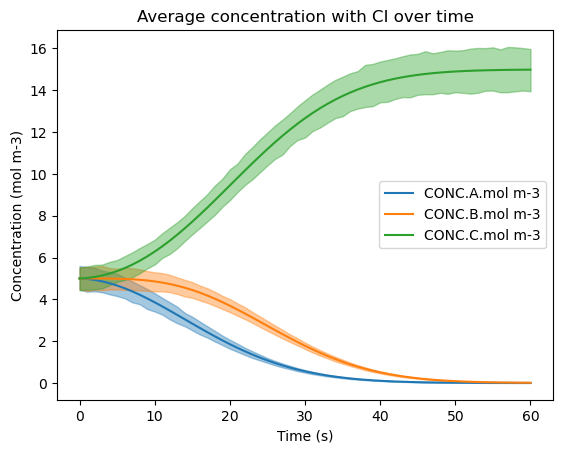

In [7]:
sns.lineplot(data=df, x='time.s', y='CONC.A.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.A.mol m-3')
sns.lineplot(data=df, x='time.s', y='CONC.B.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.B.mol m-3')
sns.lineplot(data=df, x='time.s', y='CONC.C.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.C.mol m-3')
plt.title('Average concentration with CI over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='center right')
plt.show()

### 6b. Visualizing the Min-Max Curve
This figure is similar to the CI curves above, but it instead displays the range of values for each species at each time step.</br>
To build this figure, the min and max at every time step are found and populated into their respective arrays to represent the bottom curve and top curve for each species.</br>
All of the curves are then plotted for each species with a lower alpha so that the overlaps are visible.

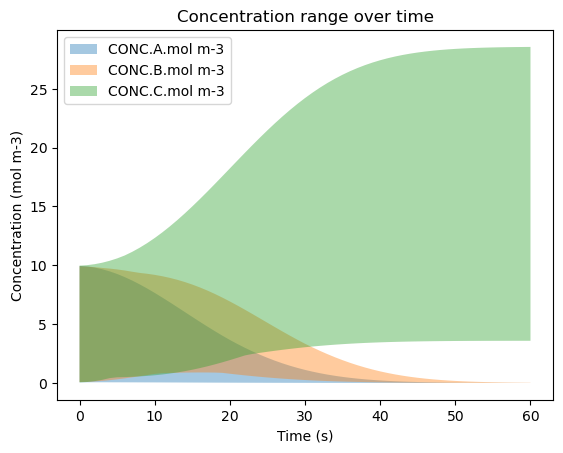

In [8]:
min_y = []
max_y = []
for i in range(0, sim_length + 1, time_step_length):
    min_y.append({species: np.min(concentration) for species, concentration in concentrations_solved[int(i/time_step_length)].items()})
    max_y.append({species: np.max(concentration) for species, concentration in concentrations_solved[int(i/time_step_length)].items()})
time_x = list(map(float, range(0, sim_length + 1, time_step_length)))

plt.fill_between(time_x, [y['A'] for y in min_y], [y['A'] for y in max_y], alpha = 0.4, label='CONC.A.mol m-3')
plt.fill_between(time_x, [y['B'] for y in min_y], [y['B'] for y in max_y], alpha = 0.4, label='CONC.B.mol m-3')
plt.fill_between(time_x, [y['C'] for y in min_y], [y['C'] for y in max_y], alpha = 0.4, label='CONC.C.mol m-3')
plt.title('Concentration range over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()